Using device: cuda:0
(480, 20)


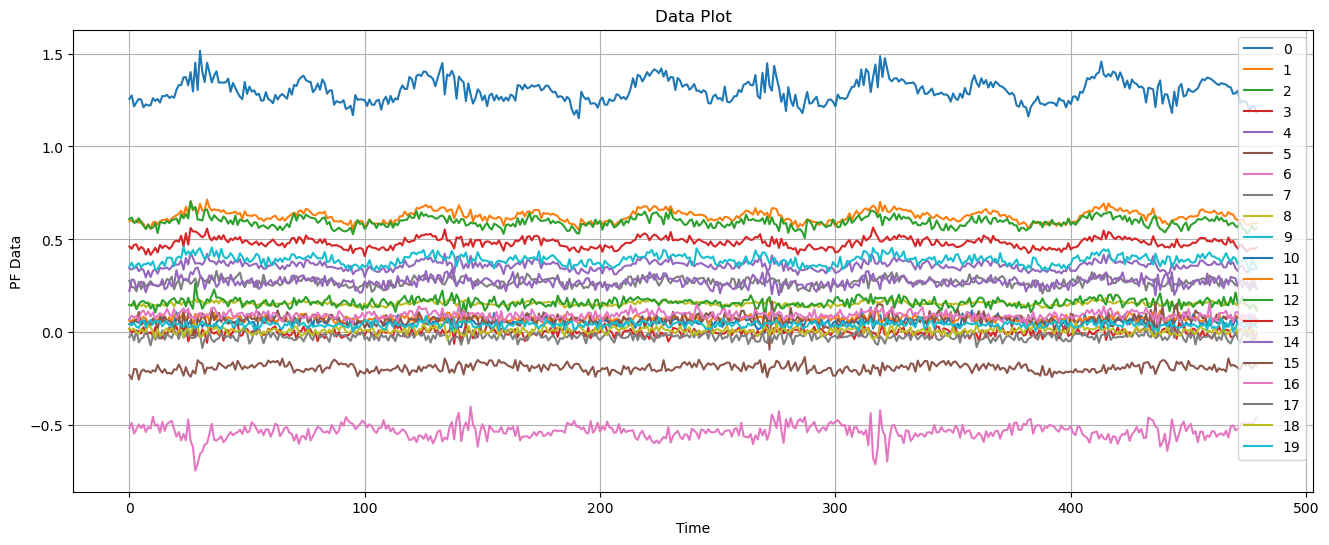

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def read_excel_power(file_path= ""):
    pfData = pd.read_excel(file_path, engine='openpyxl', sheet_name=0, parse_dates=['Timestamp'])
    phaseData = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, parse_dates=['Timestamp'])
    pfData.set_index('Timestamp', inplace=True)
    phaseData.set_index('Timestamp', inplace=True)
    pfData= pfData.to_numpy()
    phaseData= phaseData.to_numpy()
    #normalize
    #pfData= pfData/(np.sqrt(np.sum(np.square(pfData), 1, keepdims= True)))
    
    return pfData, phaseData
attackPfData, attackPhaseData= read_excel_power("first round/attack_all.xlsx")
PfData2, attackPhaseData2= read_excel_power("fdia_data.xlsx")
basePfData, basePhaseData= read_excel_power("first round/base_all.xlsx")

data= attackPfData
print(data.shape)
plt.figure(figsize=(16, 6))
for i in range(data.shape[1]):
    #plt.plot(data.index, data[i], label=i)
    plt.plot(data[:, i], label=i)
plt.title('Data Plot')
plt.xlabel('Time')
plt.ylabel('PF Data')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
from scipy.io import loadmat

# Load MATLAB file
mat_data = loadmat('matpower/topology20_14.mat')

# Access a variable inside the .mat file
A = mat_data['graph']
# 'data' is a NumPy array
print(A.shape)

(20, 14)


In [6]:
print(A)

[[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1]]


In [95]:

type0PfData= np.concatenate([PfData2[:,:]])
xDatas= np.concatenate([type0PfData])
print(xDatas.shape)
attackPfData2= PfData2[0:, :]

(1440, 20)


In [45]:

# Define the model
class Net(nn.Module):
    def __init__(self, A):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 18)   # Input layer
        self.fc12 = nn.Linear(18, 16)   # Input layer
        self.fc13 = nn.Linear(16, 14)   # Input layer
        self.fc2 = nn.Linear(14, 20)
        self.H = torch.randn((20, 14), dtype= torch.float64, device=device)*1e-6 # Hidden layer
        self.A= torch.tensor(A, device= device)
        self.VecBias= torch.randn((1, 14), dtype= torch.float64, device=device)*1e-6
        self.VecBias= torch.nn.Parameter(self.VecBias)
        self.H= torch.nn.Parameter(self.H)
    def encoder(self, x):
        y1 = torch.nn.Sigmoid()(self.fc1(x))
        y1 = torch.nn.Sigmoid()(self.fc12(y1))
        y1 = self.fc13(y1)
        y1= y1+torch.rand((y1.shape[0], 1), device= device)
        
        return y1
    def decoder(self, y1):
        x = (model.H.sum(dim=1, keepdim=True)*model.A).matmul((y1).T)
        #x= self.fc2(y1)
        return x.T
    def forward(self, x):
        y1, y2= self.encoder(x)
        x_pre= self.decoder(y1, y2)
        return x_pre
# Create the model and move it to the GPU
model = Net(A).to(device, dtype=torch.float64)
losses= []

In [46]:


# Convert data to PyTorch tensors
x_tensor = torch.tensor(xDatas, dtype=torch.float64, device=device)

# Create a DataLoader
dataset = TensorDataset(x_tensor, x_tensor)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()
# criterion= nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)



In [61]:
# Training the model
epochs = 80000
for epoch in tqdm(range(epochs)):
    for inputs, label in loader:
        optimizer.zero_grad()
        y1 = model.encoder(inputs)
        p_x = model.decoder(y1)
        MSELoss = criterion(p_x, inputs)
        loss= MSELoss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

print("Training complete.")
print(loss)
print(MSELoss)

100%|██████████| 80000/80000 [16:54<00:00, 78.89it/s]

Training complete.
tensor(2.2219e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(2.2219e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


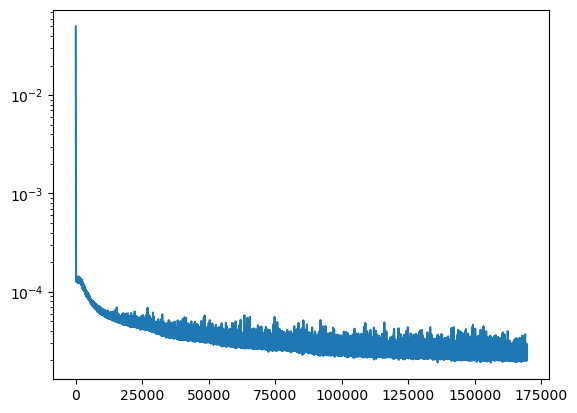

In [62]:
plt.plot(losses[:])
plt.yscale("log")
#plt.xscale("log")

(1440, 20)


Text(0, 0.5, '|y^2|')

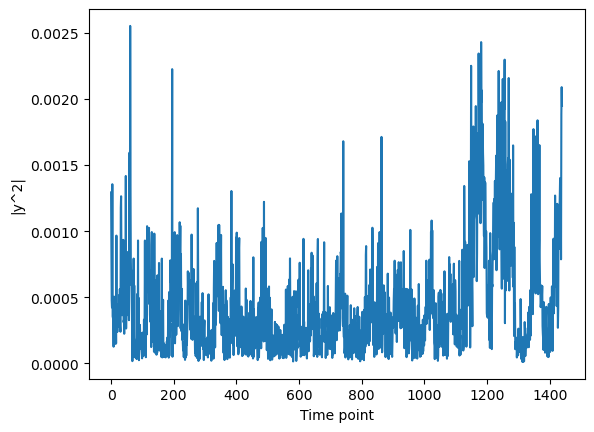

In [63]:
def apply_mean_filter_2d(data, window_size):
    # Define the filter kernel
    filter_kernel = np.ones(window_size) / window_size
    # Initialize the output array with the same shape as input
    filtered_data = np.zeros_like(data)
    # Apply the filter along each row
    for i in range(data.shape[1]):
        filtered_data[:, i] = np.convolve(data[:, i], filter_kernel, mode='same')
    return filtered_data

x_test_tensor = torch.tensor(attackPfData2, dtype=torch.float64, device=device)
y1= model.encoder(x_test_tensor)
o_x= model.decoder(y1)
bias= torch.square(x_test_tensor-o_x).detach().cpu().numpy()
print(bias.shape)
bias= apply_mean_filter_2d(bias, 1).sum(axis=1)
ob_o_y= torch.sum(torch.square(y1), dim= 1)
plt.plot(bias)
plt.xlabel("Time point")
plt.ylabel("|y^2|")